In [325]:
import re
import pickle

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter
from textblob import TextBlob
from itertools import combinations
from tqdm import tqdm

from litecoder.db import City

In [326]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [327]:
def tokenize(text):
    return [str(t) for t in TextBlob(text).tokens]

In [328]:
def keyify(text):
    text = text.lower()
    text = re.sub('[^a-z0-9]', '', text)
    return text

In [329]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __hash__(self):
        # TODO: Class identifier?
        return hash((self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)
    
    def label(self):
        return '<%s>' % self.token_clean
    
    def key(self):
        return keyify(self.token)

In [330]:
class GeoFSA(nx.MultiDiGraph):
    
    def __init__(self):
        super().__init__()
        self._next_id = 0
#         self.start_node = self.next_node()
        
    def add_node(self, node, **kwargs):
        """Initialize final set to all nodes.
        """
        defaults = dict(final=set())
        super().add_node(node, **{**defaults, **kwargs})
        
    def add_edge(self, u, v, entity=None, **kwargs):
        """Ensure edges have non-empty entity sets.
        """
        defaults = dict(accept_fn=None, entities=set([entity]), label=None)
        
        kwargs = {**defaults, **kwargs}
        
        if not len(kwargs['entities']) > 0:
            raise RuntimeError('All edges must have a non-empty entity set.')
        
        super().add_edge(u, v, **{**defaults, **kwargs})
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = self._next_id
        
        self.add_node(node)
        self._next_id += 1
        
        return node
        
    def add_token(self, accept_fn, entity, parent=None, optional=False):
        """Register a token transition.
        """
        s1 = parent if parent else self.next_node()
        s2 = self.next_node()
        
        self.add_edge(
            s1, s2, entity,
            accept_fn=accept_fn,
            label=accept_fn.label(),
        )
        
        last_node = s2
        
        # Add skip links if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, entity, label='ε')
            self.add_edge(s1, s3, entity, label='ε')
            last_node = s3
        
        return last_node
    
    def set_final(self, state, entity):
        self.node[state]['final'].add(entity)

    def start_nodes(self):
        return [n for n in self.nodes() if self.in_degree(n) == 0]
    
    def inner_nodes(self):
        return [n for n in self.nodes() if self.in_degree(n) > 0]
    
    def _merge_nodes(self, u, v):
        """Merge two leaf nodes.
        """
        # Add v finals -> u finals.
        self.node[u]['final'].update(g.node[v]['final'])
        
        # Redirect in edges.
        for s, _, data in g.in_edges(v, data=True):
            g.add_edge(s, u, **data)
            
        # Redirect out edges.
        for _, t, data in g.out_edges(v, data=True):
            g.add_edge(u, t, **data)
            
        self.remove_node(v)
        
    def _merge_edges(self, u, v, k1, k2):
        """Merge two edges between a pair of nodes.
        """
        # Add k2 entities -> k1 entities.
        self[u][v][k1]['entities'].update(self[u][v][k2]['entities'])
        
        self.remove_edge(u, v, k2)
        
    def _start_node_merge_key(self, node):
        """Build merge key for end node.
        """
        return frozenset([
            data.get('accept_fn')
            for _, _, data in self.out_edges(node, data=True)
        ])
    
    def _inner_node_merge_key(self, node):
        """Build merge key for inner node.
        """
        out_edges = frozenset([
            data.get('accept_fn')
            for _, _, data in self.in_edges(node, data=True)
        ])
        
        predecessors = frozenset(self.predecessors(node))
        
        return (out_edges, predecessors)
                
    def reduce_start_nodes(self):
        """Reduce all redundant start nodes.
        """
        seen = {}
        for v in self.start_nodes():
            
            key = self._start_node_merge_key(v)
            u = seen.get(key)
            
            if u is not None:
                self._merge_nodes(u, v)  
            else:
                seen[key] = v
        
    def _reduce_inner_nodes_once(self):
        """Perform one iteration of right-side inner node reduction.
        """
        seen = {}
        for v in self.inner_nodes():
            
            key = self._inner_node_merge_key(v)
            u = seen.get(key)
            
            if u is not None:
                self._merge_nodes(u, v)
            else:
                seen[key] = v
                    
    def reduce_inner_nodes(self):
        """Reduce inner nodes until no more merges are possible.
        """
        while True:
            nc1 = len(self.nodes)
            self._reduce_inner_nodes_once()
            nc2 = len(self.nodes)
            if nc2 == nc1:
                break
                
    def reduce_edges(self):
        """Reduce out edges for all nodes.
        """
        for node in self.nodes():
            
            out_edges = list(self.out_edges(node, data=True, keys=True))

            seen = {}
            for s, t, k2, data in out_edges:

                key = (t, data['accept_fn'])
                k1 = seen.get(key)

                if k1 is not None:
                    self._merge_edges(s, t, k1, k2)

                else:
                    seen[key] = k2
            
    def reduce(self):
        self.reduce_start_nodes()
        self.reduce_inner_nodes()
        self.reduce_edges()
            
    # TODO
    def add_city(self, city):

        name_tokens = tokenize(city.name)
        state_tokens = tokenize(city.name_a1)

        # City name
        parent = None
        for token in name_tokens:
            parent = self.add_token(Token(token), city.fsa_entity, parent)
            
        if (city.population or 0) > 500000:
            self.set_final(parent, city.fsa_entity)

        # Optional comma
        comma = self.add_token(Token(','), city.fsa_entity, parent, optional=True)

        # State name
        parent = comma
        for token in state_tokens:
            parent = self.add_token(Token(token), city.fsa_entity, parent)

        self.set_final(parent, city.fsa_entity)

        # Or, state abbr
        leaf = self.add_token(Token(city.us_state_abbr), city.fsa_entity, comma)
        self.set_final(leaf, city.fsa_entity)

In [331]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

In [333]:
g = GeoFSA()

for city in tqdm(City.query.filter(City.country_iso=='US').limit(10)):
    g.add_city(city)


0it [00:00, ?it/s]
10it [00:00, 1528.43it/s]

In [334]:
pickle.dump(g, open('test', 'wb'))

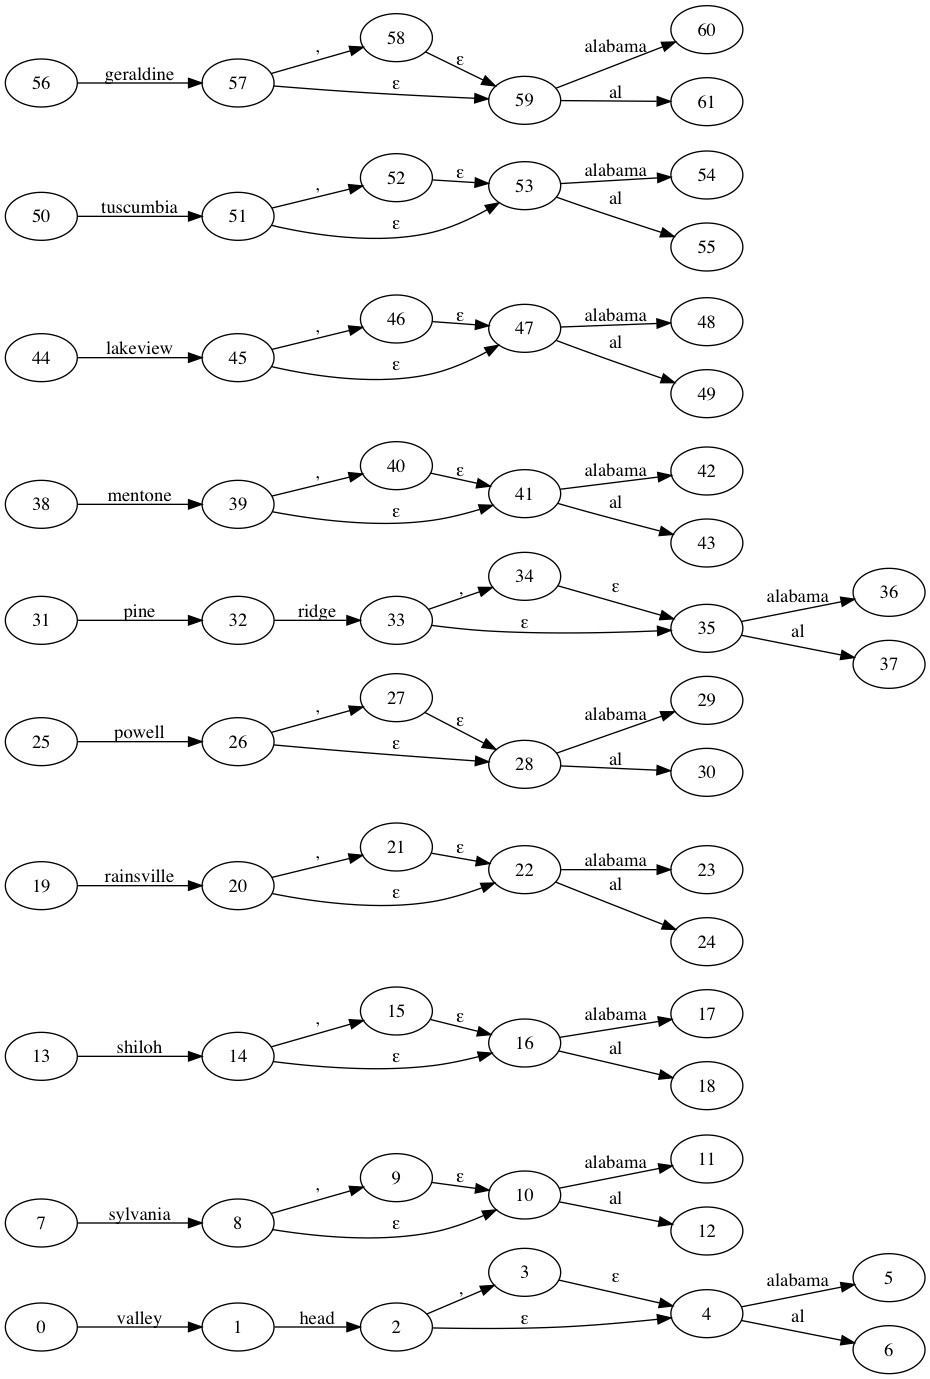

In [335]:
plot(g)

In [336]:
la = City.query.filter(City.name=='Los Angeles').first()
lg = City.query.filter(City.name=='Los Gatos').first()

In [337]:
g.add_city(la)
g.add_city(lg)

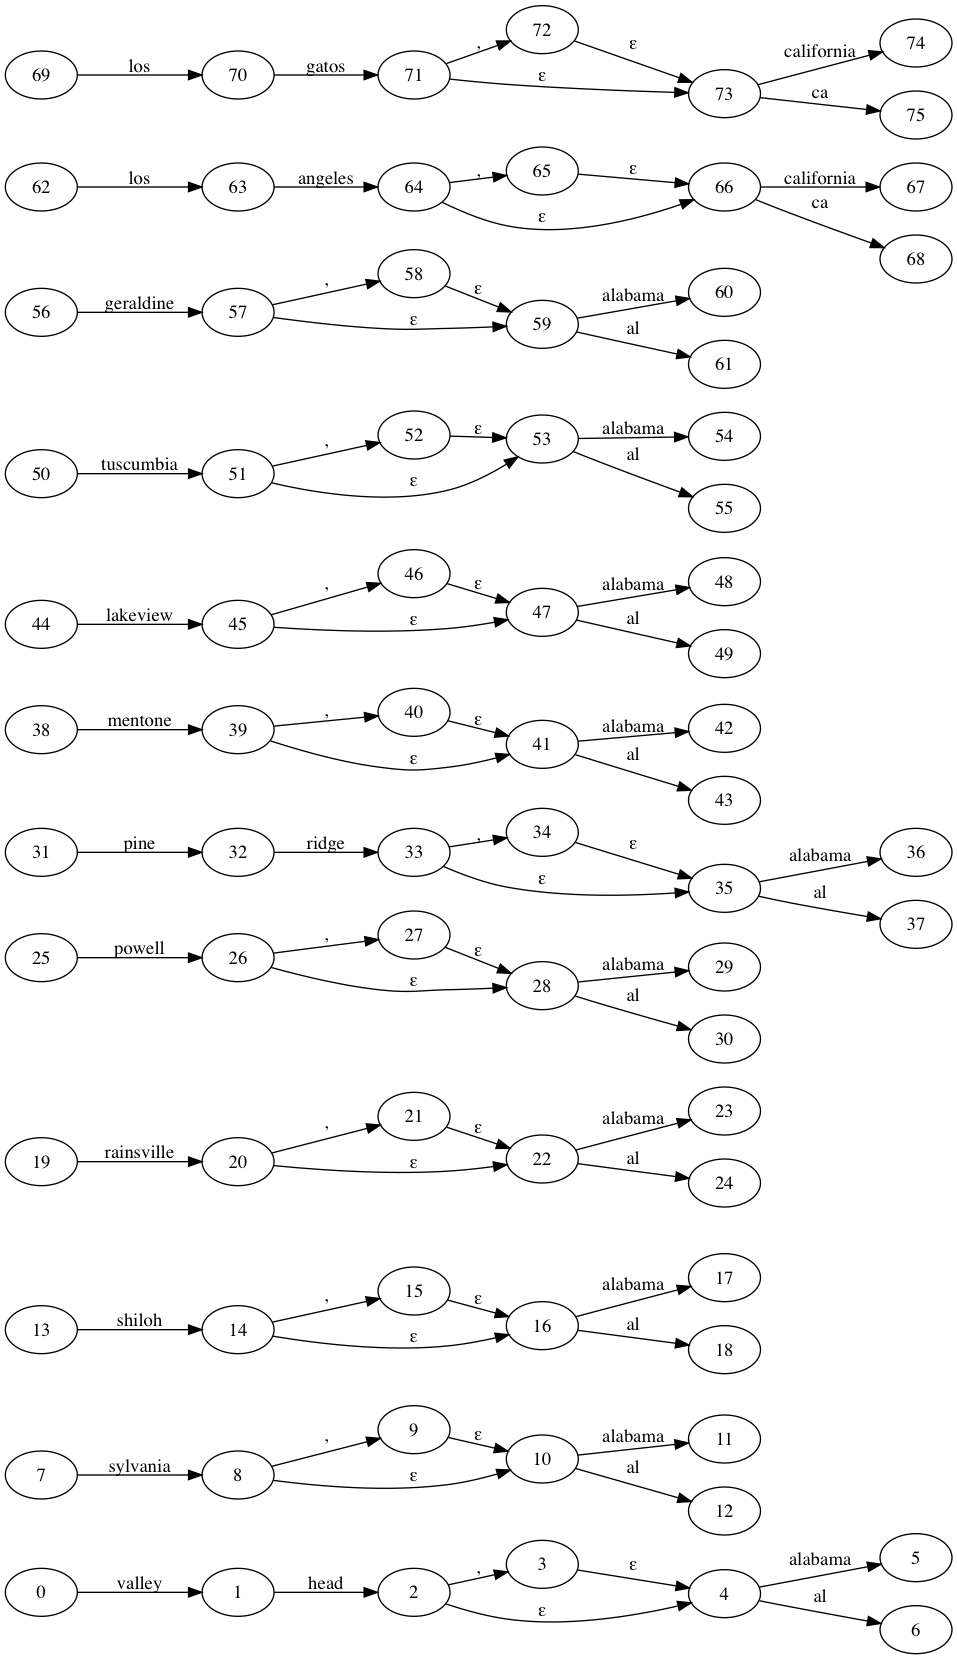

In [338]:
plot(g)

In [339]:
g.reduce()

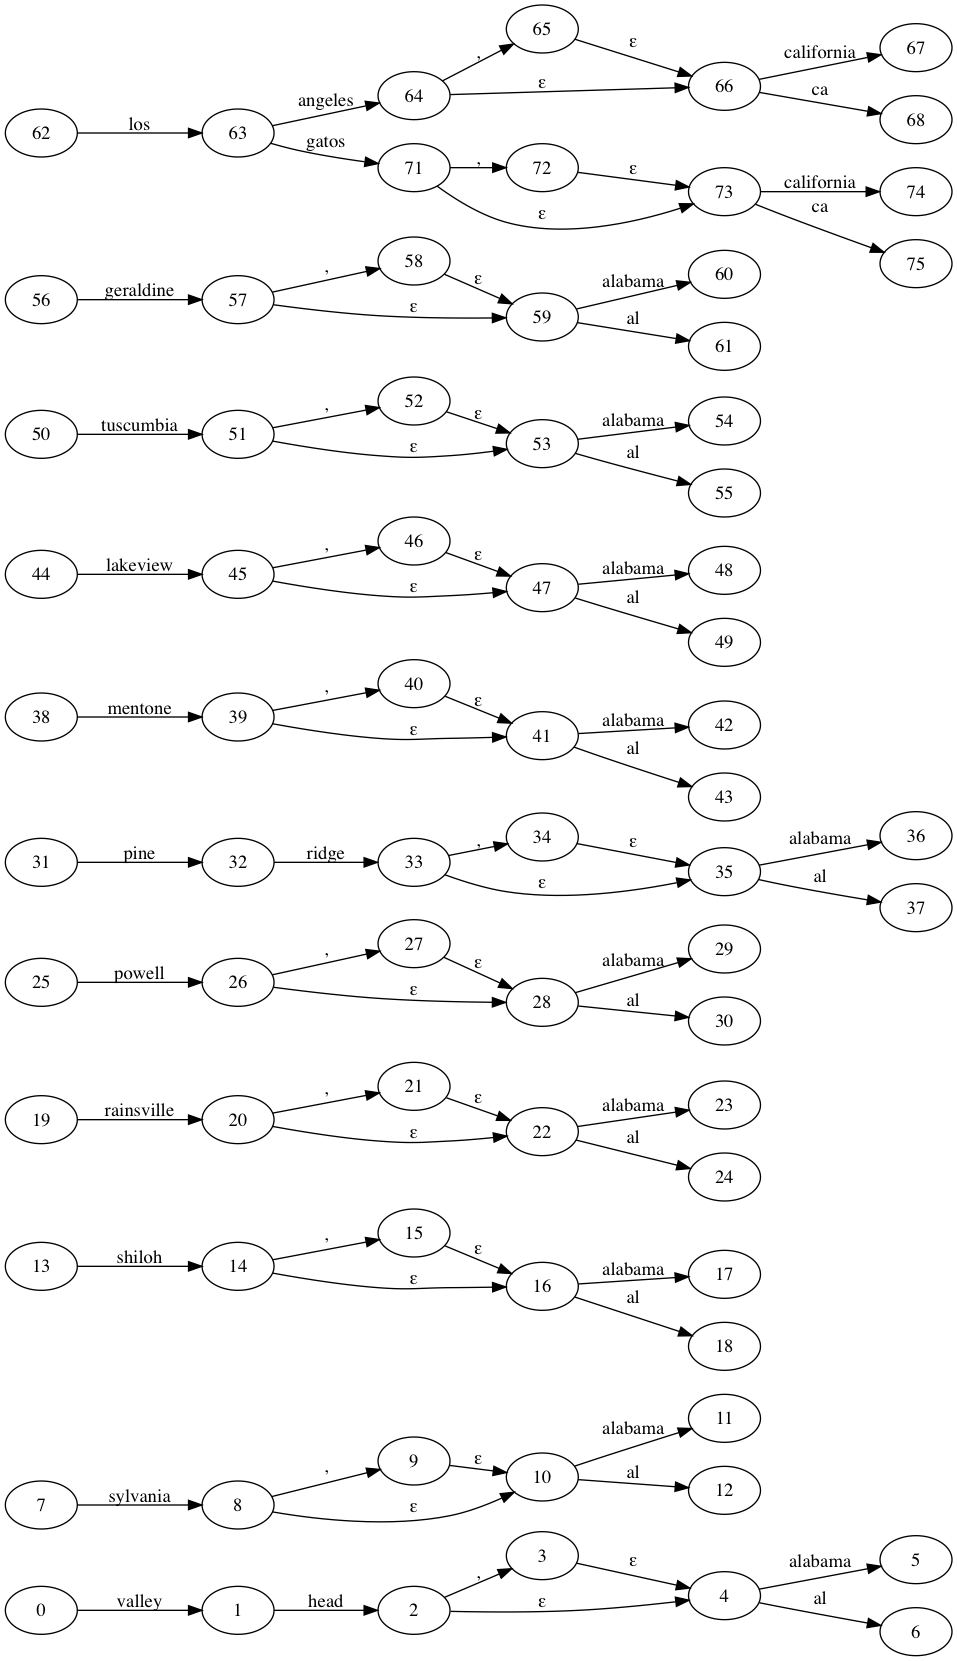

In [340]:
plot(g)

In [341]:
g[0][1]

AtlasView({0: {'accept_fn': Token<valley>, 'entities': {('city', 85897411)}, 'label': '<valley>'}})

In [342]:
g.node[5]

{'final': {('city', 85897411)}}